# Curiosity-driven exploration with causality prior in VectorIncrement environment

Based on https://pathak22.github.io/noreward-rl/

Setting the right GPU

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

Imports

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tqdm import tqdm

tf.compat.v1.enable_v2_behavior()

from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics, py_metrics
from tf_agents.policies import random_tf_policy, epsilon_greedy_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.networks import actor_distribution_network
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.specs import array_spec
from tf_agents.environments import utils, wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.drivers import py_driver

from vectorincrement import *
from common import *
from curiosity import *

Environment hyperparameters

In [3]:
v_n = 2
v_k = 2
v_seed = 43
do_transform = True
time_limit = 20

Agent hyperparameters

In [4]:
num_iterations = 500 # @param {type:"integer"}
collect_episodes_per_iteration = 5 # @param {type:"integer"}
replay_buffer_capacity = 1000 # @param {type:"integer"}

fc_layer_params = ()

learning_rate = 1e-3 # @param {type:"number"}
log_interval = 25 # @param {type:"integer"}
num_eval_episodes = 10 # @param {type:"integer"}
eval_interval = 10 # @param {type:"integer"}

Decoder: a linear transformation from observations to features

In [5]:
l2_decoder_coeff = 1e-3 # to prevent weight explosion from the l1 loss

In [6]:
# two layers, will sync parameters between them

decoder_layer = tf.keras.layers.Dense(v_n, input_shape=(v_k,), activation=None,
                             use_bias=False, kernel_initializer='random_normal',
                             kernel_regularizer = tf.keras.regularizers.l2(l2_decoder_coeff))

decoder_layer_agent = tf.keras.layers.Dense(v_n, input_shape=(v_k,), activation=None,
                             use_bias=False, kernel_initializer='random_normal',
                             kernel_regularizer = tf.keras.regularizers.l2(l2_decoder_coeff))

decoder = tf.keras.Sequential(
    [
        decoder_layer
    ]
)

Model of the environment

In [7]:
l1coeff = 1e-2

model_train_epochs = 10

In [8]:
env_model = tf.keras.Sequential([
    m_passthrough_action(decoder, v_k, v_n),
    tf.keras.layers.InputLayer(input_shape=(v_k + v_n,)), # input: [state, one-hot action]
    tf.keras.layers.Dense(v_k, kernel_regularizer=tf.keras.regularizers.l1(l1coeff)) # output: state
])

env_model.compile('adam', 'mse')

Curiosity parameters

In [9]:
alpha = 1.0

curiosity_interval = 20

Creating a curiosity-wrapped environment

In [10]:
def get_env(add_curiosity_reward=True):
    """Return a copy of the environment."""
    env = VectorIncrementEnvironmentTFAgents(v_n=v_n, v_k=v_k, v_seed=v_seed,
                                             do_transform=do_transform)
    env = wrappers.TimeLimit(env, time_limit)
    if add_curiosity_reward:
        env = CuriosityWrapper(env, env_model, alpha=alpha)
    env = tf_py_environment.TFPyEnvironment(env)
    return env

In [11]:
train_env = get_env(add_curiosity_reward=True)
eval_env = get_env(add_curiosity_reward=False)

In [12]:
actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params,
    activation_fn=tf.keras.activations.relu,
    preprocessing_layers=decoder_layer_agent
    # for features: add preprocessing_layers=[...]
)

In [13]:
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

tf_agent = reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns=True,
    train_step_counter=train_step_counter)
tf_agent.initialize()

In [14]:
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

In [15]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

In [16]:
curiosity_replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=1000000) # should never overflow

In [17]:
decoder_layer_agent = actor_net.layers[0].layers[0] # taking the copied layer with actual weights

Agent train step
DECODER:[[-0.0697959  -0.00308524]
 [-0.00708889  0.04244918]]
MODEL:[array([[ 0.25339055,  0.9880707 ],
       [ 0.03676939,  0.5841136 ],
       [ 0.05980778, -0.7604344 ],
       [-0.9825578 , -0.6252358 ]], dtype=float32), array([0., 0.], dtype=float32)]
Agent train step
DECODER:[[-0.06977716 -0.00313098]
 [-0.00706076  0.0423805 ]]
MODEL:[array([[ 0.25339055,  0.9880707 ],
       [ 0.03676939,  0.5841136 ],
       [ 0.05980778, -0.7604344 ],
       [-0.9825578 , -0.6252358 ]], dtype=float32), array([0., 0.], dtype=float32)]
Agent train step
DECODER:[[-0.06972814 -0.00325062]
 [-0.00688241  0.04194515]]
MODEL:[array([[ 0.25339055,  0.9880707 ],
       [ 0.03676939,  0.5841136 ],
       [ 0.05980778, -0.7604344 ],
       [-0.9825578 , -0.6252358 ]], dtype=float32), array([0., 0.], dtype=float32)]
Agent train step
DECODER:[[-0.06972394 -0.00326089]
 [-0.00687853  0.04193568]]
MODEL:[array([[ 0.25339055,  0.9880707 ],
       [ 0.03676939,  0.5841136 ],
       [ 0.0598

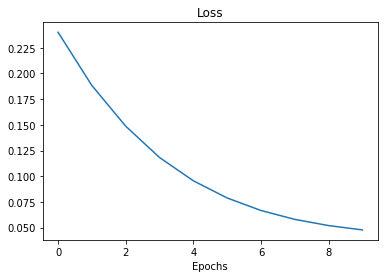

Model train step
DECODER:[[0.2616532  0.3481533 ]
 [0.4304377  0.49231288]]
MODEL:[array([[ 0.00702249,  0.8601975 ],
       [ 0.02774482,  0.6687271 ],
       [-0.3886295 , -0.41740286],
       [-0.58533955, -0.35065615]], dtype=float32), array([0.28682694, 0.25298247], dtype=float32)]
Agent train step
DECODER:[[0.2616339  0.34820047]
 [0.43038574 0.49243984]]
MODEL:[array([[ 0.00702249,  0.8601975 ],
       [ 0.02774482,  0.6687271 ],
       [-0.3886295 , -0.41740286],
       [-0.58533955, -0.35065615]], dtype=float32), array([0.28682694, 0.25298247], dtype=float32)]
Agent train step
DECODER:[[0.26157278 0.34835026]
 [0.43028224 0.49269342]]
MODEL:[array([[ 0.00702249,  0.8601975 ],
       [ 0.02774482,  0.6687271 ],
       [-0.3886295 , -0.41740286],
       [-0.58533955, -0.35065615]], dtype=float32), array([0.28682694, 0.25298247], dtype=float32)]
Agent train step
DECODER:[[0.26162633 0.34821805]
 [0.43057117 0.49198022]]
MODEL:[array([[ 0.00702249,  0.8601975 ],
       [ 0.0277448

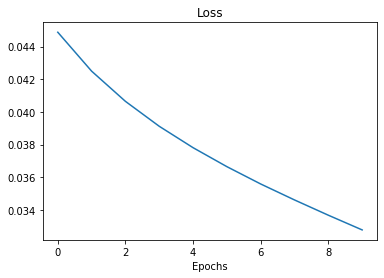

Model train step
DECODER:[[0.2945217  0.4739922 ]
 [0.63726455 0.76593053]]
MODEL:[array([[ 0.0223561 ,  0.59410274],
       [ 0.1849441 ,  0.5598321 ],
       [-0.40909985, -0.2536603 ],
       [-0.46281332, -0.1917012 ]], dtype=float32), array([0.33364636, 0.15779427], dtype=float32)]
Agent train step
DECODER:[[0.29450354 0.4740356 ]
 [0.637211   0.7660585 ]]
MODEL:[array([[ 0.0223561 ,  0.59410274],
       [ 0.1849441 ,  0.5598321 ],
       [-0.40909985, -0.2536603 ],
       [-0.46281332, -0.1917012 ]], dtype=float32), array([0.33364636, 0.15779427], dtype=float32)]
Agent train step
DECODER:[[0.294554   0.47391444]
 [0.63734424 0.7657386 ]]
MODEL:[array([[ 0.0223561 ,  0.59410274],
       [ 0.1849441 ,  0.5598321 ],
       [-0.40909985, -0.2536603 ],
       [-0.46281332, -0.1917012 ]], dtype=float32), array([0.33364636, 0.15779427], dtype=float32)]
Agent train step
DECODER:[[0.294529   0.47397378]
 [0.63724786 0.7659672 ]]
MODEL:[array([[ 0.0223561 ,  0.59410274],
       [ 0.1849441

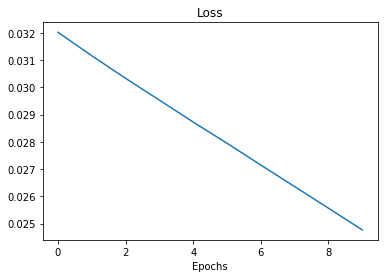

Model train step
DECODER:[[0.23084377 0.6133662 ]
 [0.76521456 1.0177594 ]]
MODEL:[array([[-5.4170756e-05,  3.5289386e-01],
       [ 2.0046882e-01,  5.5519509e-01],
       [-3.3606198e-01, -5.2315682e-02],
       [-3.8120636e-01,  3.7500507e-04]], dtype=float32), array([ 0.2962324 , -0.03525696], dtype=float32)]
Agent train step
DECODER:[[0.23086415 0.6133208 ]
 [0.76518935 1.0178156 ]]
MODEL:[array([[-5.4170756e-05,  3.5289386e-01],
       [ 2.0046882e-01,  5.5519509e-01],
       [-3.3606198e-01, -5.2315682e-02],
       [-3.8120636e-01,  3.7500507e-04]], dtype=float32), array([ 0.2962324 , -0.03525696], dtype=float32)]
Agent train step
DECODER:[[0.23090063 0.6132395 ]
 [0.76530534 1.0175569 ]]
MODEL:[array([[-5.4170756e-05,  3.5289386e-01],
       [ 2.0046882e-01,  5.5519509e-01],
       [-3.3606198e-01, -5.2315682e-02],
       [-3.8120636e-01,  3.7500507e-04]], dtype=float32), array([ 0.2962324 , -0.03525696], dtype=float32)]
Agent train step
DECODER:[[0.23093542 0.6131628 ]
 [0.7654

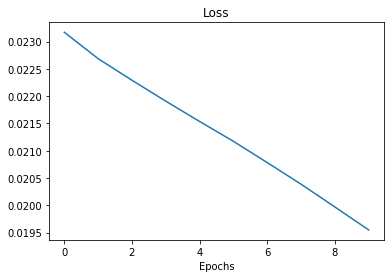

Model train step
DECODER:[[0.16398233 0.6277303 ]
 [0.78129417 1.2602577 ]]
MODEL:[array([[-3.7879661e-05,  4.9412508e-02],
       [ 1.6905008e-01,  6.2143594e-01],
       [-2.3917998e-01, -1.0905923e-02],
       [-2.8096202e-01,  2.5465437e-03]], dtype=float32), array([ 0.2109356 , -0.07982906], dtype=float32)]
Agent train step
DECODER:[[0.16400844 0.62767756]
 [0.7814799  1.2598825 ]]
MODEL:[array([[-3.7879661e-05,  4.9412508e-02],
       [ 1.6905008e-01,  6.2143594e-01],
       [-2.3917998e-01, -1.0905923e-02],
       [-2.8096202e-01,  2.5465437e-03]], dtype=float32), array([ 0.2109356 , -0.07982906], dtype=float32)]
Agent train step
DECODER:[[0.16396649 0.6277608 ]
 [0.78139454 1.2600518 ]]
MODEL:[array([[-3.7879661e-05,  4.9412508e-02],
       [ 1.6905008e-01,  6.2143594e-01],
       [-2.3917998e-01, -1.0905923e-02],
       [-2.8096202e-01,  2.5465437e-03]], dtype=float32), array([ 0.2109356 , -0.07982906], dtype=float32)]
Agent train step
DECODER:[[0.16400607 0.62768155]
 [0.7816

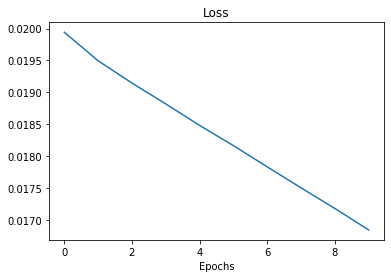

Model train step
DECODER:[[0.08910719 0.50076973]
 [0.6867313  1.4542991 ]]
MODEL:[array([[-7.9209363e-05, -1.2317757e-04],
       [ 1.4579496e-01,  6.0148138e-01],
       [-1.0819080e-01, -8.6290659e-03],
       [-1.5493727e-01,  7.1916240e-03]], dtype=float32), array([ 0.07932546, -0.0748201 ], dtype=float32)]
Agent train step
DECODER:[[0.08912386 0.50073874]
 [0.6867296  1.4543022 ]]
MODEL:[array([[-7.9209363e-05, -1.2317757e-04],
       [ 1.4579496e-01,  6.0148138e-01],
       [-1.0819080e-01, -8.6290659e-03],
       [-1.5493727e-01,  7.1916240e-03]], dtype=float32), array([ 0.07932546, -0.0748201 ], dtype=float32)]
Agent train step
DECODER:[[0.08914264 0.5007038 ]
 [0.6867524  1.4542599 ]]
MODEL:[array([[-7.9209363e-05, -1.2317757e-04],
       [ 1.4579496e-01,  6.0148138e-01],
       [-1.0819080e-01, -8.6290659e-03],
       [-1.5493727e-01,  7.1916240e-03]], dtype=float32), array([ 0.07932546, -0.0748201 ], dtype=float32)]
Agent train step
DECODER:[[0.08904423 0.50088626]
 [0.6865

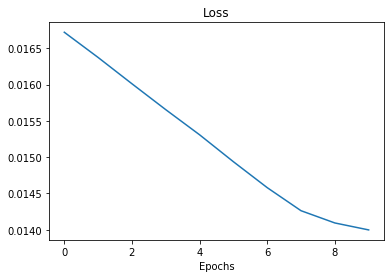

Model train step
DECODER:[[0.03860596 0.47553313]
 [0.57267016 1.5766976 ]]
MODEL:[array([[-9.9619145e-05,  2.4870061e-04],
       [ 1.3514741e-01,  5.6002665e-01],
       [ 1.6035606e-03, -7.4162977e-03],
       [-7.6319827e-03,  7.5783404e-03]], dtype=float32), array([-0.06497507, -0.07353118], dtype=float32)]
Agent train step
DECODER:[[0.03861576 0.4755169 ]
 [0.5727796  1.5765163 ]]
MODEL:[array([[-9.9619145e-05,  2.4870061e-04],
       [ 1.3514741e-01,  5.6002665e-01],
       [ 1.6035606e-03, -7.4162977e-03],
       [-7.6319827e-03,  7.5783404e-03]], dtype=float32), array([-0.06497507, -0.07353118], dtype=float32)]
Agent train step
DECODER:[[0.03861934 0.475511  ]
 [0.57281184 1.5764633 ]]
MODEL:[array([[-9.9619145e-05,  2.4870061e-04],
       [ 1.3514741e-01,  5.6002665e-01],
       [ 1.6035606e-03, -7.4162977e-03],
       [-7.6319827e-03,  7.5783404e-03]], dtype=float32), array([-0.06497507, -0.07353118], dtype=float32)]
Agent train step
DECODER:[[0.03863002 0.47549355]
 [0.5728

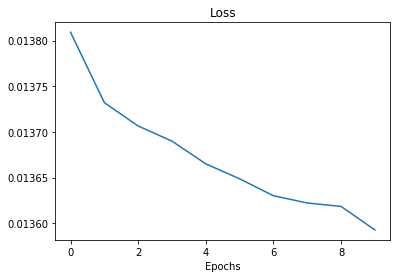

Model train step
DECODER:[[0.01200761 0.48736277]
 [0.44609103 1.6502407 ]]
MODEL:[array([[ 3.9444494e-05, -2.8108432e-05],
       [ 1.3146539e-01,  5.3273571e-01],
       [ 6.2228180e-05, -6.5015275e-03],
       [-1.8447556e-04,  7.6626493e-03]], dtype=float32), array([-0.07839871, -0.0727257 ], dtype=float32)]
Agent train step
DECODER:[[0.01195519 0.4874455 ]
 [0.44606066 1.6502886 ]]
MODEL:[array([[ 3.9444494e-05, -2.8108432e-05],
       [ 1.3146539e-01,  5.3273571e-01],
       [ 6.2228180e-05, -6.5015275e-03],
       [-1.8447556e-04,  7.6626493e-03]], dtype=float32), array([-0.07839871, -0.0727257 ], dtype=float32)]
Agent train step
DECODER:[[0.01194709 0.48745835]
 [0.4460914  1.6502398 ]]
MODEL:[array([[ 3.9444494e-05, -2.8108432e-05],
       [ 1.3146539e-01,  5.3273571e-01],
       [ 6.2228180e-05, -6.5015275e-03],
       [-1.8447556e-04,  7.6626493e-03]], dtype=float32), array([-0.07839871, -0.0727257 ], dtype=float32)]
Agent train step
DECODER:[[0.0119418  0.4874667 ]
 [0.4461

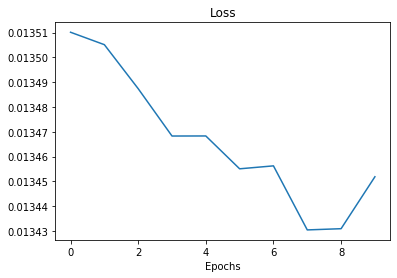

Model train step
DECODER:[[0.00246589 0.45937043]
 [0.31677338 1.6957347 ]]
MODEL:[array([[ 2.16153363e-04,  3.25847504e-04],
       [ 1.24978386e-01,  5.25018752e-01],
       [ 4.13317233e-04, -7.04583293e-03],
       [-4.45077225e-04,  9.61423852e-03]], dtype=float32), array([-0.08216651, -0.07186172], dtype=float32)]
Agent train step
DECODER:[[0.0024335  0.45942426]
 [0.31660607 1.6960129 ]]
MODEL:[array([[ 2.16153363e-04,  3.25847504e-04],
       [ 1.24978386e-01,  5.25018752e-01],
       [ 4.13317233e-04, -7.04583293e-03],
       [-4.45077225e-04,  9.61423852e-03]], dtype=float32), array([-0.08216651, -0.07186172], dtype=float32)]
Agent train step
DECODER:[[0.00236212 0.45954436]
 [0.3165054  1.6961823 ]]
MODEL:[array([[ 2.16153363e-04,  3.25847504e-04],
       [ 1.24978386e-01,  5.25018752e-01],
       [ 4.13317233e-04, -7.04583293e-03],
       [-4.45077225e-04,  9.61423852e-03]], dtype=float32), array([-0.08216651, -0.07186172], dtype=float32)]
Agent train step
DECODER:[[0.00239

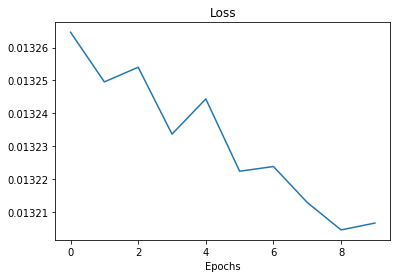

Model train step
DECODER:[[3.5022228e-04 4.3940130e-01]
 [1.9933294e-01 1.7157142e+00]]
MODEL:[array([[ 4.1385400e-05, -4.5105837e-05],
       [ 1.1919319e-01,  5.2076507e-01],
       [ 2.5619694e-03, -6.6224057e-03],
       [-2.7864608e-03,  7.1907574e-03]], dtype=float32), array([-0.07987358, -0.07304406], dtype=float32)]
Agent train step
DECODER:[[3.1217225e-04 4.3946394e-01]
 [1.9927542e-01 1.7158089e+00]]
MODEL:[array([[ 4.1385400e-05, -4.5105837e-05],
       [ 1.1919319e-01,  5.2076507e-01],
       [ 2.5619694e-03, -6.6224057e-03],
       [-2.7864608e-03,  7.1907574e-03]], dtype=float32), array([-0.07987358, -0.07304406], dtype=float32)]
Agent train step
DECODER:[[2.9979320e-04 4.3948442e-01]
 [1.9926035e-01 1.7158338e+00]]
MODEL:[array([[ 4.1385400e-05, -4.5105837e-05],
       [ 1.1919319e-01,  5.2076507e-01],
       [ 2.5619694e-03, -6.6224057e-03],
       [-2.7864608e-03,  7.1907574e-03]], dtype=float32), array([-0.07987358, -0.07304406], dtype=float32)]
Agent train step
DECOD

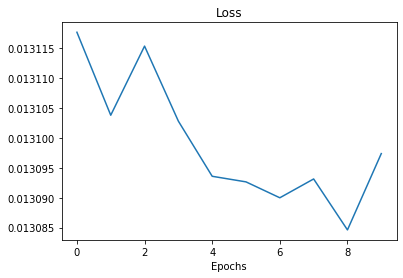

Model train step
DECODER:[[3.9682767e-05 4.1027087e-01]
 [1.0631341e-01 1.7244147e+00]]
MODEL:[array([[-9.65827348e-05, -3.45076842e-04],
       [ 1.09753840e-01,  5.22738874e-01],
       [ 1.45231793e-03, -7.41460826e-03],
       [-3.25053930e-03,  1.10057015e-02]], dtype=float32), array([-0.07813464, -0.07123956], dtype=float32)]
Agent train step
DECODER:[[7.89562182e-05 4.10208941e-01]
 [1.06511444e-01 1.72410250e+00]]
MODEL:[array([[-9.65827348e-05, -3.45076842e-04],
       [ 1.09753840e-01,  5.22738874e-01],
       [ 1.45231793e-03, -7.41460826e-03],
       [-3.25053930e-03,  1.10057015e-02]], dtype=float32), array([-0.07813464, -0.07123956], dtype=float32)]
Agent train step
DECODER:[[9.19244339e-05 4.10188764e-01]
 [1.06460534e-01 1.72418177e+00]]
MODEL:[array([[-9.65827348e-05, -3.45076842e-04],
       [ 1.09753840e-01,  5.22738874e-01],
       [ 1.45231793e-03, -7.41460826e-03],
       [-3.25053930e-03,  1.10057015e-02]], dtype=float32), array([-0.07813464, -0.07123956], dtype=

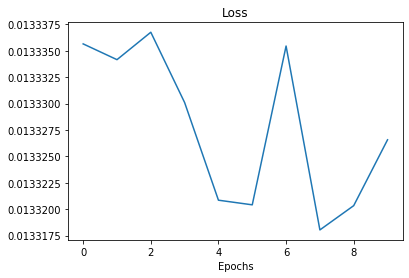

Model train step
DECODER:[[3.8341332e-06 4.1131404e-01]
 [4.5213632e-02 1.7280301e+00]]
MODEL:[array([[ 8.55579128e-05,  3.20613763e-05],
       [ 1.13181286e-01,  5.20919681e-01],
       [ 1.77267822e-04, -5.17988391e-03],
       [-2.81338254e-03,  9.87332594e-03]], dtype=float32), array([-0.08413888, -0.07043276], dtype=float32)]
Agent train step
DECODER:[[1.3598916e-05 4.1129977e-01]
 [4.5210503e-02 1.7280346e+00]]
MODEL:[array([[ 8.55579128e-05,  3.20613763e-05],
       [ 1.13181286e-01,  5.20919681e-01],
       [ 1.77267822e-04, -5.17988391e-03],
       [-2.81338254e-03,  9.87332594e-03]], dtype=float32), array([-0.08413888, -0.07043276], dtype=float32)]
Agent train step
DECODER:[[-8.7913040e-06  4.1133249e-01]
 [ 4.5213867e-02  1.7280297e+00]]
MODEL:[array([[ 8.55579128e-05,  3.20613763e-05],
       [ 1.13181286e-01,  5.20919681e-01],
       [ 1.77267822e-04, -5.17988391e-03],
       [-2.81338254e-03,  9.87332594e-03]], dtype=float32), array([-0.08413888, -0.07043276], dtype=floa

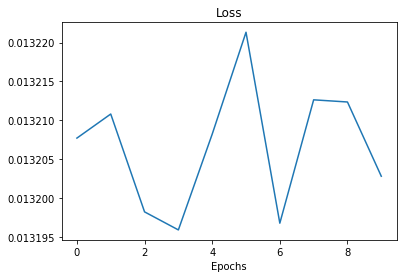

Model train step
DECODER:[[-1.4394347e-05  4.2992997e-01]
 [ 1.4104359e-02  1.7254647e+00]]
MODEL:[array([[-1.6619099e-04, -1.0105617e-04],
       [ 1.1988901e-01,  5.1529813e-01],
       [ 1.7801544e-04, -4.7214287e-03],
       [-3.3681418e-03,  1.0832315e-02]], dtype=float32), array([-0.0787426 , -0.06959317], dtype=float32)]
Agent train step
DECODER:[[1.7540511e-05 4.2988726e-01]
 [1.4269798e-02 1.7252434e+00]]
MODEL:[array([[-1.6619099e-04, -1.0105617e-04],
       [ 1.1988901e-01,  5.1529813e-01],
       [ 1.7801544e-04, -4.7214287e-03],
       [-3.3681418e-03,  1.0832315e-02]], dtype=float32), array([-0.0787426 , -0.06959317], dtype=float32)]
Agent train step
DECODER:[[4.9433704e-05 4.2984509e-01]
 [1.4471142e-02 1.7249773e+00]]
MODEL:[array([[-1.6619099e-04, -1.0105617e-04],
       [ 1.1988901e-01,  5.1529813e-01],
       [ 1.7801544e-04, -4.7214287e-03],
       [-3.3681418e-03,  1.0832315e-02]], dtype=float32), array([-0.0787426 , -0.06959317], dtype=float32)]
Agent train step
D

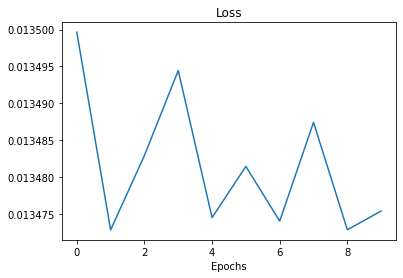

Model train step
DECODER:[[8.5724088e-05 4.1410735e-01]
 [2.7675424e-03 1.7296553e+00]]
MODEL:[array([[-1.9066400e-04, -1.4277939e-05],
       [ 1.1515499e-01,  5.1954842e-01],
       [ 1.4108466e-03, -4.5119221e-03],
       [-1.2170125e-03,  7.2849155e-03]], dtype=float32), array([-0.08383934, -0.07162404], dtype=float32)]
Agent train step
DECODER:[[1.1809720e-04 4.1406429e-01]
 [2.8997669e-03 1.7294794e+00]]
MODEL:[array([[-1.9066400e-04, -1.4277939e-05],
       [ 1.1515499e-01,  5.1954842e-01],
       [ 1.4108466e-03, -4.5119221e-03],
       [-1.2170125e-03,  7.2849155e-03]], dtype=float32), array([-0.08383934, -0.07162404], dtype=float32)]
Agent train step
DECODER:[[1.3915381e-04 4.1403654e-01]
 [2.9288079e-03 1.7294412e+00]]
MODEL:[array([[-1.9066400e-04, -1.4277939e-05],
       [ 1.1515499e-01,  5.1954842e-01],
       [ 1.4108466e-03, -4.5119221e-03],
       [-1.2170125e-03,  7.2849155e-03]], dtype=float32), array([-0.08383934, -0.07162404], dtype=float32)]
Agent train step
DECOD

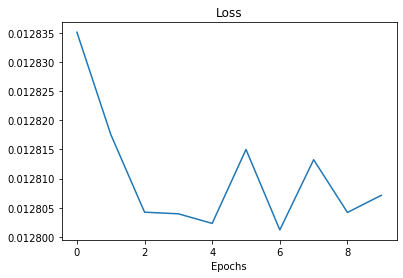

Model train step
DECODER:[[6.9492671e-05 4.8581317e-01]
 [3.6970561e-04 1.7217380e+00]]
MODEL:[array([[ 7.9804129e-05, -2.4029006e-05],
       [ 1.3109125e-01,  5.0871694e-01],
       [ 1.4154428e-04, -6.7308461e-03],
       [ 1.4364091e-04,  7.1092839e-03]], dtype=float32), array([-0.0708459 , -0.07309307], dtype=float32)]
Agent train step
DECODER:[[1.6953985e-04 4.8568267e-01]
 [6.4541964e-04 1.7213783e+00]]
MODEL:[array([[ 7.9804129e-05, -2.4029006e-05],
       [ 1.3109125e-01,  5.0871694e-01],
       [ 1.4154428e-04, -6.7308461e-03],
       [ 1.4364091e-04,  7.1092839e-03]], dtype=float32), array([-0.0708459 , -0.07309307], dtype=float32)]
Agent train step
DECODER:[[1.7489011e-04 4.8567584e-01]
 [6.5505016e-04 1.7213660e+00]]
MODEL:[array([[ 7.9804129e-05, -2.4029006e-05],
       [ 1.3109125e-01,  5.0871694e-01],
       [ 1.4154428e-04, -6.7308461e-03],
       [ 1.4364091e-04,  7.1092839e-03]], dtype=float32), array([-0.0708459 , -0.07309307], dtype=float32)]
Agent train step
DECOD

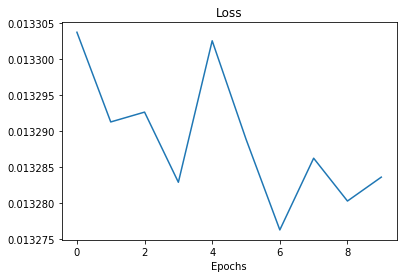

Model train step
DECODER:[[-4.0007595e-05  4.5264518e-01]
 [ 8.0358208e-05  1.7246751e+00]]
MODEL:[array([[-1.3462306e-04,  2.2271861e-04],
       [ 1.2179308e-01,  5.1553863e-01],
       [ 8.9882547e-04, -5.0364407e-03],
       [-1.1143629e-03,  1.1371916e-02]], dtype=float32), array([-0.08550096, -0.06946354], dtype=float32)]
Agent train step
DECODER:[[6.5067150e-05 4.5252383e-01]
 [3.9017285e-04 1.7243172e+00]]
MODEL:[array([[-1.3462306e-04,  2.2271861e-04],
       [ 1.2179308e-01,  5.1553863e-01],
       [ 8.9882547e-04, -5.0364407e-03],
       [-1.1143629e-03,  1.1371916e-02]], dtype=float32), array([-0.08550096, -0.06946354], dtype=float32)]
Agent train step
DECODER:[[6.3119332e-05 4.5252603e-01]
 [3.5301025e-04 1.7243590e+00]]
MODEL:[array([[-1.3462306e-04,  2.2271861e-04],
       [ 1.2179308e-01,  5.1553863e-01],
       [ 8.9882547e-04, -5.0364407e-03],
       [-1.1143629e-03,  1.1371916e-02]], dtype=float32), array([-0.08550096, -0.06946354], dtype=float32)]
Agent train step
D

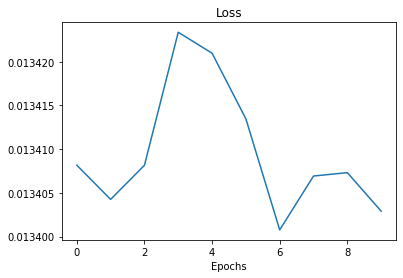

Model train step
DECODER:[[-7.8261051e-05  4.4384715e-01]
 [-6.4484935e-05  1.7257612e+00]]
MODEL:[array([[-3.3220229e-05,  2.2389057e-05],
       [ 1.1980379e-01,  5.1619399e-01],
       [ 2.9216136e-03, -6.7874687e-03],
       [-4.2178243e-04,  8.6672138e-03]], dtype=float32), array([-0.07923067, -0.07223164], dtype=float32)]
Agent train step
DECODER:[[-2.3855528e-05  4.4378629e-01]
 [ 1.0477941e-04  1.7255719e+00]]
MODEL:[array([[-3.3220229e-05,  2.2389057e-05],
       [ 1.1980379e-01,  5.1619399e-01],
       [ 2.9216136e-03, -6.7874687e-03],
       [-4.2178243e-04,  8.6672138e-03]], dtype=float32), array([-0.07923067, -0.07223164], dtype=float32)]
Agent train step
DECODER:[[-1.0029676e-04  4.4387054e-01]
 [-6.4851250e-05  1.7257589e+00]]
MODEL:[array([[-3.3220229e-05,  2.2389057e-05],
       [ 1.1980379e-01,  5.1619399e-01],
       [ 2.9216136e-03, -6.7874687e-03],
       [-4.2178243e-04,  8.6672138e-03]], dtype=float32), array([-0.07923067, -0.07223164], dtype=float32)]
Agent trai

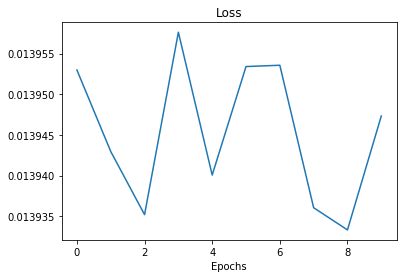

Model train step
DECODER:[[-9.3721283e-05  4.7492123e-01]
 [ 1.7569546e-05  1.7233329e+00]]
MODEL:[array([[-1.6374814e-05,  9.3860290e-05],
       [ 1.3124065e-01,  5.0843579e-01],
       [ 9.3404646e-04, -6.6581639e-03],
       [-4.2879102e-03,  9.4126593e-03]], dtype=float32), array([-0.07770209, -0.07172297], dtype=float32)]
Agent train step
DECODER:[[-1.2548587e-04  4.7495919e-01]
 [-3.7521066e-05  1.7233987e+00]]
MODEL:[array([[-1.6374814e-05,  9.3860290e-05],
       [ 1.3124065e-01,  5.0843579e-01],
       [ 9.3404646e-04, -6.6581639e-03],
       [-4.2879102e-03,  9.4126593e-03]], dtype=float32), array([-0.07770209, -0.07172297], dtype=float32)]
Agent train step
DECODER:[[-1.1760238e-04  4.7494972e-01]
 [-1.3498077e-05  1.7233698e+00]]
MODEL:[array([[-1.6374814e-05,  9.3860290e-05],
       [ 1.3124065e-01,  5.0843579e-01],
       [ 9.3404646e-04, -6.6581639e-03],
       [-4.2879102e-03,  9.4126593e-03]], dtype=float32), array([-0.07770209, -0.07172297], dtype=float32)]
Agent trai

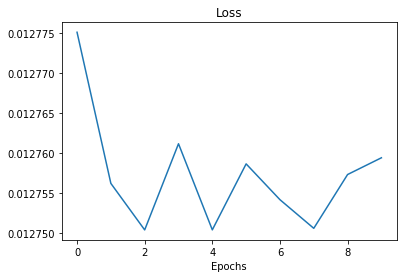

Model train step
DECODER:[[-1.26002386e-04  4.97150838e-01]
 [-1.11371104e-04  1.72106838e+00]]
MODEL:[array([[-2.3054488e-05, -2.8724759e-04],
       [ 1.3090844e-01,  5.0992423e-01],
       [ 2.3259046e-03, -7.5680912e-03],
       [-3.9368772e-04,  6.2346114e-03]], dtype=float32), array([-0.07033276, -0.07428586], dtype=float32)]
Agent train step
DECODER:[[-1.2692768e-04  4.9715197e-01]
 [-9.2657778e-05  1.7210457e+00]]
MODEL:[array([[-2.3054488e-05, -2.8724759e-04],
       [ 1.3090844e-01,  5.0992423e-01],
       [ 2.3259046e-03, -7.5680912e-03],
       [-3.9368772e-04,  6.2346114e-03]], dtype=float32), array([-0.07033276, -0.07428586], dtype=float32)]
Agent train step
DECODER:[[-1.10378365e-04  4.97132003e-01]
 [-7.88798425e-05  1.72102904e+00]]
MODEL:[array([[-2.3054488e-05, -2.8724759e-04],
       [ 1.3090844e-01,  5.0992423e-01],
       [ 2.3259046e-03, -7.5680912e-03],
       [-3.9368772e-04,  6.2346114e-03]], dtype=float32), array([-0.07033276, -0.07428586], dtype=float32)]
Ag

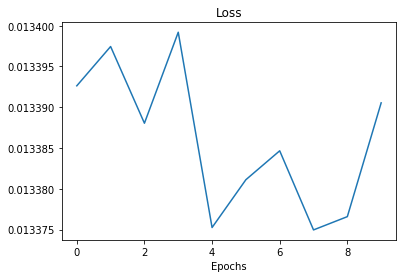

Model train step
DECODER:[[ 1.16071205e-04  4.49490249e-01]
 [-4.31966555e-06  1.72481036e+00]]
MODEL:[array([[-5.0606195e-05, -1.8634516e-04],
       [ 1.2290409e-01,  5.1447999e-01],
       [-5.6338229e-04, -4.8173843e-03],
       [ 2.4962355e-07,  9.0803560e-03]], dtype=float32), array([-0.07903707, -0.07074606], dtype=float32)]
Agent train step
DECODER:[[ 1.1276087e-04  4.4949374e-01]
 [-2.4662264e-05  1.7248318e+00]]
MODEL:[array([[-5.0606195e-05, -1.8634516e-04],
       [ 1.2290409e-01,  5.1447999e-01],
       [-5.6338229e-04, -4.8173843e-03],
       [ 2.4962355e-07,  9.0803560e-03]], dtype=float32), array([-0.07903707, -0.07074606], dtype=float32)]
Agent train step
DECODER:[[1.2673794e-04 4.4947898e-01]
 [4.8055652e-05 1.7247550e+00]]
MODEL:[array([[-5.0606195e-05, -1.8634516e-04],
       [ 1.2290409e-01,  5.1447999e-01],
       [-5.6338229e-04, -4.8173843e-03],
       [ 2.4962355e-07,  9.0803560e-03]], dtype=float32), array([-0.07903707, -0.07074606], dtype=float32)]
Agent trai

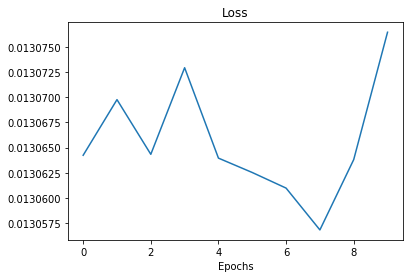

Model train step
DECODER:[[ 8.3184786e-05  4.8473546e-01]
 [-6.0529299e-05  1.7222238e+00]]
MODEL:[array([[ 2.9007613e-04,  6.2086227e-05],
       [ 1.3185623e-01,  5.0942260e-01],
       [ 8.0513928e-05, -4.9815099e-03],
       [-4.8539322e-04,  7.0895469e-03]], dtype=float32), array([-0.07482475, -0.07208916], dtype=float32)]
Agent train step
DECODER:[[1.1853957e-04 4.8469654e-01]
 [4.4830154e-05 1.7221078e+00]]
MODEL:[array([[ 2.9007613e-04,  6.2086227e-05],
       [ 1.3185623e-01,  5.0942260e-01],
       [ 8.0513928e-05, -4.9815099e-03],
       [-4.8539322e-04,  7.0895469e-03]], dtype=float32), array([-0.07482475, -0.07208916], dtype=float32)]
Agent train step
DECODER:[[1.1211075e-04 4.8470354e-01]
 [3.6497488e-05 1.7221168e+00]]
MODEL:[array([[ 2.9007613e-04,  6.2086227e-05],
       [ 1.3185623e-01,  5.0942260e-01],
       [ 8.0513928e-05, -4.9815099e-03],
       [-4.8539322e-04,  7.0895469e-03]], dtype=float32), array([-0.07482475, -0.07208916], dtype=float32)]
Agent train step
D

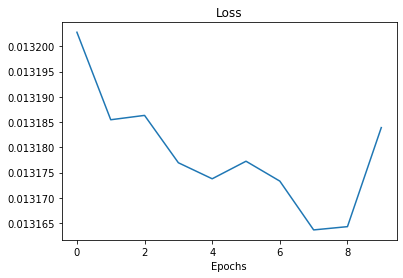

Model train step
DECODER:[[ 2.8406645e-04  4.4819823e-01]
 [-3.1266383e-05  1.7264785e+00]]
MODEL:[array([[-1.6949359e-04,  2.6616424e-05],
       [ 1.2176654e-01,  5.1629174e-01],
       [ 2.1859338e-03, -5.2068126e-03],
       [-7.9829205e-04,  7.0027299e-03]], dtype=float32), array([-0.07860404, -0.07230429], dtype=float32)]
Agent train step
DECODER:[[3.5206837e-04 4.4812736e-01]
 [1.3829472e-04 1.7263018e+00]]
MODEL:[array([[-1.6949359e-04,  2.6616424e-05],
       [ 1.2176654e-01,  5.1629174e-01],
       [ 2.1859338e-03, -5.2068126e-03],
       [-7.9829205e-04,  7.0027299e-03]], dtype=float32), array([-0.07860404, -0.07230429], dtype=float32)]
Agent train step
DECODER:[[3.8976336e-04 4.4808871e-01]
 [2.8025816e-04 1.7261562e+00]]
MODEL:[array([[-1.6949359e-04,  2.6616424e-05],
       [ 1.2176654e-01,  5.1629174e-01],
       [ 2.1859338e-03, -5.2068126e-03],
       [-7.9829205e-04,  7.0027299e-03]], dtype=float32), array([-0.07860404, -0.07230429], dtype=float32)]
Agent train step
D

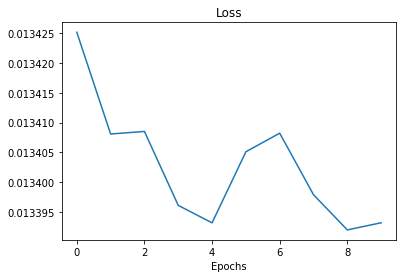

Model train step
DECODER:[[ 1.8610060e-04  4.7768691e-01]
 [-1.0432015e-05  1.7224398e+00]]
MODEL:[array([[ 1.80515606e-04,  4.01859288e-05],
       [ 1.29734725e-01,  5.10023594e-01],
       [-1.14791925e-04, -5.18017029e-03],
       [-3.07382364e-03,  1.13381939e-02]], dtype=float32), array([-0.08226208, -0.06959337], dtype=float32)]
Agent train step
DECODER:[[ 1.15872521e-04  4.77756113e-01]
 [-1.16087955e-04  1.72254384e+00]]
MODEL:[array([[ 1.80515606e-04,  4.01859288e-05],
       [ 1.29734725e-01,  5.10023594e-01],
       [-1.14791925e-04, -5.18017029e-03],
       [-3.07382364e-03,  1.13381939e-02]], dtype=float32), array([-0.08226208, -0.06959337], dtype=float32)]
Agent train step
DECODER:[[ 1.4108987e-04  4.7773099e-01]
 [-2.5628768e-05  1.7224537e+00]]
MODEL:[array([[ 1.80515606e-04,  4.01859288e-05],
       [ 1.29734725e-01,  5.10023594e-01],
       [-1.14791925e-04, -5.18017029e-03],
       [-3.07382364e-03,  1.13381939e-02]], dtype=float32), array([-0.08226208, -0.06959337]

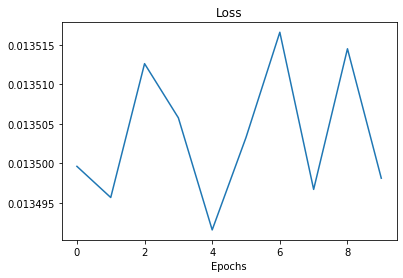

Model train step
DECODER:[[-8.2032196e-04  4.9549332e-01]
 [-5.3657178e-04  1.7209593e+00]]
MODEL:[array([[-1.3825645e-04,  2.1485591e-04],
       [ 1.3509957e-01,  5.0684255e-01],
       [ 1.2729915e-03, -6.8501704e-03],
       [-2.2665495e-03,  8.3693424e-03]], dtype=float32), array([-0.07201147, -0.07249265], dtype=float32)]
Agent train step
DECODER:[[-8.2910794e-04  4.9550202e-01]
 [-5.3672958e-04  1.7209594e+00]]
MODEL:[array([[-1.3825645e-04,  2.1485591e-04],
       [ 1.3509957e-01,  5.0684255e-01],
       [ 1.2729915e-03, -6.8501704e-03],
       [-2.2665495e-03,  8.3693424e-03]], dtype=float32), array([-0.07201147, -0.07249265], dtype=float32)]
Agent train step
DECODER:[[-7.7850802e-04  4.9545181e-01]
 [-3.8696182e-04  1.7208108e+00]]
MODEL:[array([[-1.3825645e-04,  2.1485591e-04],
       [ 1.3509957e-01,  5.0684255e-01],
       [ 1.2729915e-03, -6.8501704e-03],
       [-2.2665495e-03,  8.3693424e-03]], dtype=float32), array([-0.07201147, -0.07249265], dtype=float32)]
Agent trai

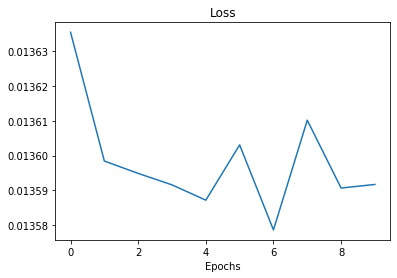

Model train step
DECODER:[[-4.1821494e-04  4.2733189e-01]
 [ 2.0206583e-04  1.7281022e+00]]
MODEL:[array([[ 1.2658408e-04, -8.9503548e-05],
       [ 1.1736352e-01,  5.1863742e-01],
       [ 1.8650031e-03, -6.4313565e-03],
       [-8.1390352e-04,  9.4971899e-03]], dtype=float32), array([-0.08381835, -0.07155113], dtype=float32)]
Agent train step
DECODER:[[-3.6684910e-04  4.2728978e-01]
 [ 3.7972731e-04  1.7279565e+00]]
MODEL:[array([[ 1.2658408e-04, -8.9503548e-05],
       [ 1.1736352e-01,  5.1863742e-01],
       [ 1.8650031e-03, -6.4313565e-03],
       [-8.1390352e-04,  9.4971899e-03]], dtype=float32), array([-0.08381835, -0.07155113], dtype=float32)]
Agent train step
DECODER:[[-4.3463436e-04  4.2734420e-01]
 [ 2.8159126e-04  1.7280353e+00]]
MODEL:[array([[ 1.2658408e-04, -8.9503548e-05],
       [ 1.1736352e-01,  5.1863742e-01],
       [ 1.8650031e-03, -6.4313565e-03],
       [-8.1390352e-04,  9.4971899e-03]], dtype=float32), array([-0.08381835, -0.07155113], dtype=float32)]
Agent trai

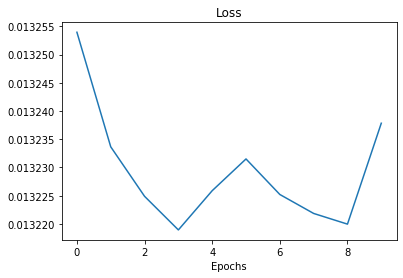

Model train step
DECODER:[[ 1.0450029e-04  4.9015599e-01]
 [-2.4217597e-04  1.7220677e+00]]
MODEL:[array([[-1.8454093e-04, -2.3500546e-04],
       [ 1.3126345e-01,  5.0940210e-01],
       [-1.3580291e-04, -7.2934804e-03],
       [-8.6255110e-04,  7.0312656e-03]], dtype=float32), array([-0.07087477, -0.07355558], dtype=float32)]


In [18]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
train_avg_return = compute_avg_return(eval_env, tf_agent.collect_policy, num_eval_episodes)
returns = [avg_return]
train_returns = [train_avg_return]
curiosity_loss = []

def print_weights():
    """Show weights."""
    print("DECODER:" + str(decoder_layer_agent.get_weights()[0]))
    print("MODEL:" + str(env_model.layers[2].get_weights()))

for _ in range(num_iterations):

  # Collect a few episodes using collect_policy and save to the replay buffer.
  collect_episode(train_env, tf_agent.collect_policy,
                  collect_episodes_per_iteration,
                  [replay_buffer,curiosity_replay_buffer])

  # Use data from the buffer and update the agent's network.
  experience = replay_buffer.gather_all()
  train_loss = tf_agent.train(experience)
  replay_buffer.clear()
    
  print("Agent train step")
  print_weights()

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
    train_avg_return = compute_avg_return(train_env, tf_agent.collect_policy, num_eval_episodes)
    print('step = {0}: Average Return = {1} Train curiosity Average return = {2}'.format(step, avg_return,
                                                                      train_avg_return))
    returns.append(avg_return)
    train_returns.append(train_avg_return)
    
  if step % curiosity_interval == 0:
    xs, ys = buffer_to_dataset(curiosity_replay_buffer, v_n)
    
    # setting weights from the agent to the model...
    decoder_layer.set_weights(decoder_layer_agent.get_weights())
    history = env_model.fit(xs, ys, epochs=model_train_epochs, verbose=0)
    
    # setting weights from the model to the agent...
    decoder_layer_agent.set_weights(decoder_layer.get_weights())
    
    plt.title("Loss")
    plt.plot(history.history['loss'])
    curiosity_loss += list(history.history['loss'])
    plt.xlabel("Epochs")
    plt.show()
    curiosity_replay_buffer.clear()
    
    print("Model train step")
    print_weights()

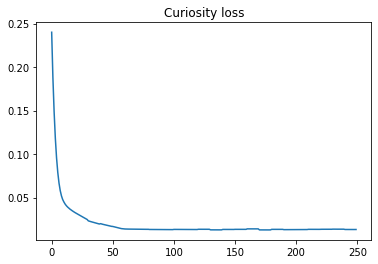

In [19]:
plt.title("Curiosity loss")
plt.plot(curiosity_loss)
plt.show()

Text(0.5, 0, 'Step')

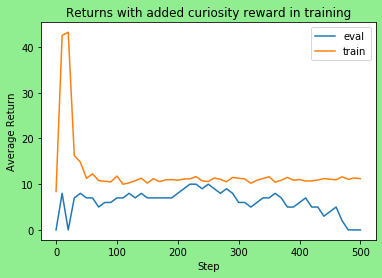

In [20]:
steps = range(0, num_iterations + 1, eval_interval)
fig = plt.figure()
fig.patch.set_facecolor('lightgreen')
plt.title("Returns with added curiosity reward in training")
plt.plot(steps, returns, label="eval")
plt.plot(steps, train_returns, label="train")
plt.ylabel('Average Return')
plt.legend()
plt.xlabel('Step')

Evaluating the model

In [21]:
curiosity_replay_buffer.clear()
collect_episode(eval_env, tf_agent.collect_policy, 25, [curiosity_replay_buffer])
collect_episode(eval_env, tf_agent.policy, 25, [curiosity_replay_buffer])
xs, ys = buffer_to_dataset(curiosity_replay_buffer, v_n)
env_model.evaluate(xs, ys)

1000/1000 [==============================] - 0s 75us/sample - loss: 0.0344


0.034379313230514526

In [22]:
env_model.weights

[<tf.Variable 'dense_5/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[ 1.0450029e-04,  4.9015599e-01],
        [-2.4217597e-04,  1.7220677e+00]], dtype=float32)>,
 <tf.Variable 'dense_7/kernel:0' shape=(4, 2) dtype=float32, numpy=
 array([[-1.8454093e-04, -2.3500546e-04],
        [ 1.3126345e-01,  5.0940210e-01],
        [-1.3580291e-04, -7.2934804e-03],
        [-8.6255110e-04,  7.0312656e-03]], dtype=float32)>,
 <tf.Variable 'dense_7/bias:0' shape=(2,) dtype=float32, numpy=array([-0.07087477, -0.07355558], dtype=float32)>]

# The problem now

Features are very similar, it's not the case that they converge to $(1,0,1,0)$ and $(0,1,0,1)$

Solutions:
1. Grid search for hyperparams
2. Using a better graph sparsity loss (approximating number of edges)